## Import Libraries

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from google.colab import drive

## Mount Drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Import Dataset

In [3]:
PATH = 'drive/My Drive/Colab Notebooks/DSAI-HW2'
print(os.listdir(PATH))

['training.csv', 'testing.csv', 'DSAI-HW2-2022.ipynb']


In [4]:
training_set = pd.read_csv(os.path.join(PATH, 'training.csv'), header=None)
testing_set = pd.read_csv(os.path.join(PATH, 'testing.csv'), header=None)
training_set.head()
# open high low close

,0,1,2,3
0,186.73,188.71,186.00,186.30
1,185.57,186.33,184.94,185.54
2,184.81,185.03,183.10,184.66
3,184.39,184.48,182.31,182.54
4,182.20,182.27,180.27,181.59


In [5]:
open_set = training_set.iloc[:,0:1].values
# high_set = training_set.iloc[:,1:2].values
# low_set = training_set.iloc[:,2:3].values
# close_set = training_set.iloc[:,3:4].values
# delta_set = close_set - open_set

In [6]:
plt.rcParams['figure.figsize'] = [17, 3]
plt.rcParams['figure.dpi'] = 100
# plt.plot(open_set)
# plt.plot(high_set)
# plt.plot(low_set)
# plt.plot(close_set)
# plt.plot(delta_set)

## Dataloading

In [7]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

def sliding_windows2(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        x.append(_x)

    return np.array(x)

In [8]:
sc = MinMaxScaler()
open_data = sc.fit_transform(open_set)

seq_length = 5
pred_length = 1
x, y = sliding_windows(open_data, seq_length)

trainX = Variable(torch.Tensor(np.array(x)))
trainY = Variable(torch.Tensor(np.array(y)))

## Model

In [9]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

## Training

[Epoch 0] train loss: 1.8877
[Epoch 10] train loss: 1.1017
[Epoch 20] train loss: 0.5977
[Epoch 30] train loss: 0.2837
[Epoch 40] train loss: 0.1075
[Epoch 50] train loss: 0.043
[Epoch 60] train loss: 0.0368
[Epoch 70] train loss: 0.0381
[Epoch 80] train loss: 0.0348
[Epoch 90] train loss: 0.0321
[Epoch 100] train loss: 0.0302
[Epoch 110] train loss: 0.028
[Epoch 120] train loss: 0.0253
[Epoch 130] train loss: 0.0224
[Epoch 140] train loss: 0.0194
[Epoch 150] train loss: 0.0163
[Epoch 160] train loss: 0.0134
[Epoch 170] train loss: 0.0106
[Epoch 180] train loss: 0.0082
[Epoch 190] train loss: 0.0061
[Epoch 200] train loss: 0.0044
[Epoch 210] train loss: 0.003
[Epoch 220] train loss: 0.002
[Epoch 230] train loss: 0.0014
[Epoch 240] train loss: 0.001
[Epoch 250] train loss: 0.0008
[Epoch 260] train loss: 0.0007
[Epoch 270] train loss: 0.0007
[Epoch 280] train loss: 0.0007
[Epoch 290] train loss: 0.0007
[Epoch 300] train loss: 0.0007
[Epoch 310] train loss: 0.0006
[Epoch 320] train loss: 

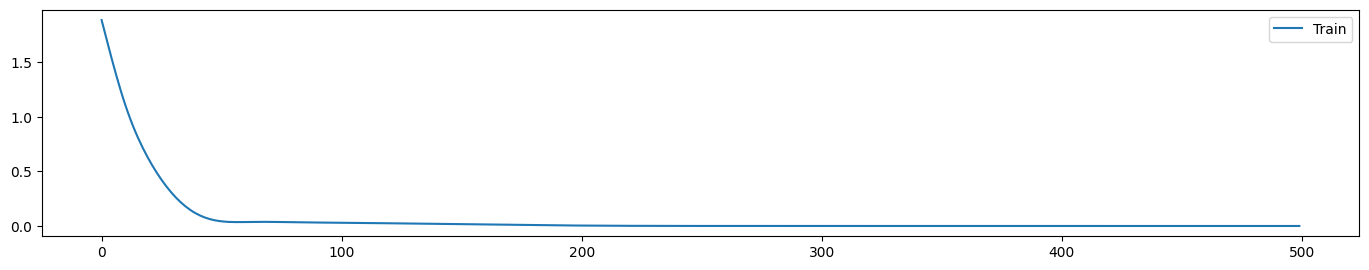

In [10]:
num_epochs = 500
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = pred_length

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    # with torch.no_grad():
    #   y_test_pred = lstm(testX)
    #   test_loss = criterion(y_test_pred, testY)
    # test_losses.append(test_loss.item())

    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()

    train_losses.append(loss.item())
    
    optimizer.step()
    if epoch % 10 == 0:
      # print(f"[Epoch {epoch}] train loss: {round(loss.item(), 4)}, test loss: {round(test_loss.item(), 4)}")
      print(f"[Epoch {epoch}] train loss: {round(loss.item(), 4)}")

plt.plot(
  train_losses,
  label='Train'
)
# plt.plot(
#   test_losses,
#   label='Test'
# )
plt.legend()

## Plotting

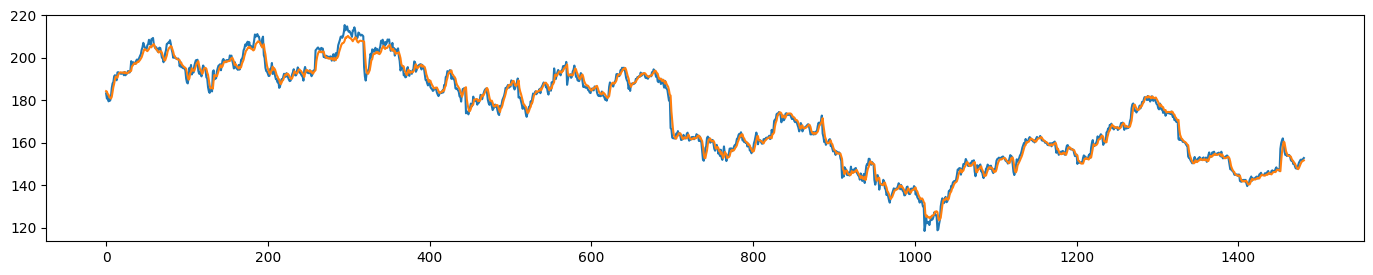

In [11]:
lstm.eval()
train_predict = lstm(trainX)

data_predict = train_predict.data.numpy()
data_real = trainY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
data_real = sc.inverse_transform(data_real)
actual_delta = data_real - data_predict

plt.plot(data_real)
plt.plot(data_predict)

## Testing

In [12]:
# concatenate traing_set last 5 elements with testing_set
open_test_set_20 = testing_set.iloc[:,0:1].values
open_test_set = np.concatenate((open_set[-5:], open_test_set_20), axis=0)
open_test_data = sc.fit_transform(open_test_set)

x = sliding_windows2(open_test_data, seq_length)

testX = Variable(torch.Tensor(np.array(x)))

lstm.eval()
pred = lstm(testX)
pred = pred.data.numpy()
pred = sc.inverse_transform(pred)
trend = []
for i in range(0, 19):
  if(pred[i] - open_test_set_20[i] < 0):
    trend.append('跌')
  else:
    trend.append('漲')
print('trend', trend)

trend ['跌', '跌', '跌', '漲', '漲', '跌', '跌', '跌', '跌', '漲', '漲', '漲', '漲', '漲', '漲', '漲', '漲', '跌', '跌']


In [13]:
curr = 0
actions = []

for i in range(0, 19):
  if(trend[i] == '跌'):
    if(curr == 0):
      actions.append(-1)
      curr = -1
    elif(curr == -1):
      actions.append(0)
      curr = -1
    else:
      actions.append(-1)
      curr = 0
  else:
    if(curr == 0):
      actions.append(1)
      curr = 1
    elif(curr == -1):
      actions.append(1)
      curr = 0
    else:
      actions.append(0)
      curr = 1

print('actions', actions)

actions [-1, 0, 0, 1, 1, -1, -1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1]


## Actions to csv

In [14]:
df = pd.DataFrame(actions)
df.to_csv('output.csv', index = False, header=None)